In [25]:
import numpy
import copy
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators.legacy.op_converter import to_weighted_pauli_operator
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit import Aer
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.operators.legacy import op_converter
from qiskit.aqua.algorithms import VQE
from qiskit.aqua import QuantumInstance
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit.aqua.components.initial_states import Custom
from qiskit.chemistry.components.initial_states import HartreeFock
import scipy

In [26]:
import warnings
warnings. filterwarnings('ignore')

In [27]:
backend = Aer.get_backend('statevector_simulator')

In [28]:
#defining number operator
def num_op(num_sites):
    N=numpy.zeros((2*num_sites,2*num_sites))
    for i in range(num_sites):
        N[i][i]=1
        N[i+num_sites][i+num_sites]=1
    qubit_N=FermionicOperator(h1=N).mapping('jordan_wigner')
    return op_converter.to_matrix_operator(qubit_N).dense_matrix
#defining spin angular momentum operator
def SpinMagnitude(num_spin_orbitals):
    Sz=numpy.zeros((num_spin_orbitals,num_spin_orbitals))*1j
    num_sites=int(num_spin_orbitals/2.)
    for i in range(num_sites):
        Sz[i,i]=1/2.
        Sz[i+num_sites,i+num_sites]=-1/2.
    qubit_Sz=FermionicOperator(h1=Sz).mapping('jordan_wigner')
    return op_converter.to_matrix_operator(qubit_Sz).dense_matrix

In [29]:
#number operator for 4 site = 8 spin orbital model
N=num_op(4)
# spin z operator
Sz=SpinMagnitude(8)

In [30]:
#Constructing the connectivity matrices for h1 one body Hamiltonian
with open('v1e.dat','r') as f:
    lines=f.readlines()[1:]
    num_sites=4
    eg_h1=numpy.zeros((2*num_sites,2*num_sites))
    for line in lines:
        elems=line.split()
        eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
        eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])

In [31]:
with open('v2e.dat','r') as f:
    num_sites=4
    eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
    for line in f:
        if "#" in line:
            continue
        line = line.split()
        i,j,k,l = map(int, line[:4])
        val = float(line[4])
        eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
        = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.

In [32]:
#chemical potential term
mu_term=numpy.zeros((2*num_sites,2*num_sites))
mu_half=7.37373737
for i in range(2*num_sites):
     mu_term[i,i]=-mu_half
eg_h1=eg_h1+mu_term        

In [33]:
def qubitOp(h1,h2):
    qubit_op=FermionicOperator(h1=h1,h2=h2).mapping('jordan_wigner')
    return qubit_op
#qubit operator rep for the eg Hamiltonian
qubit_eg=qubitOp(eg_h1,eg_h2)
eg_mat=op_converter.to_matrix_operator(qubit_eg).dense_matrix
w,v=numpy.linalg.eigh(eg_mat)
Eg=w[0]
state_g=v[:,0]
print(Eg),print(state_g.dot(N.dot(state_g)))

-12.940718999076138
(4+0j)


(None, None)

In [34]:
# def gradient(PauliOp):
#     var_form_base.push_hopping_operator(PauliOp)  
#     params=[-0.01,0.01] #delta1=-0.1, delta2=0.1
#     circ_delta1=var_form_base.construct_circuit(parameters=list(thetas)+[params[0]])
#     circ_delta2=var_form_base.construct_circuit(parameters=list(thetas)+[params[1]])
#     stateVector_1=execute(circ_delta1,backend,shots=1024).result().get_statevector()
#     stateVector_2=execute(circ_delta2,backend,shots=1024).result().get_statevector()
#     E_1=numpy.real(numpy.dot(numpy.dot(numpy.conjugate(stateVector_1),eg_mat),stateVector_1))
#     E_2=numpy.real(numpy.dot(numpy.dot(numpy.conjugate(stateVector_2),eg_mat),stateVector_2))
#     gradE=numpy.abs((E_2-E_1)/(params[1]-params[0]))
#     var_form_base.pop_hopping_operator()
#     return gradE
def gradient(data):
    PauliOp,state=data
    M=op_converter.to_matrix_operator(commutator(qubit_eg,PauliOp)).matrix
    return numpy.abs(numpy.conjugate(state).dot((M.dot(state))))

In [35]:
def E_landscape(params):
    circ=var_form_base.construct_circuit(parameters=params)
    stateVector_0=execute(circ,backend,shots=1024).result().get_statevector()
    E=numpy.real(numpy.dot(numpy.dot(numpy.conjugate(stateVector_0),eg_mat),stateVector_0)) 
    return E

In [36]:
#commutator between operators
def commutator(A,B):
    op_commutator=[A.multiply(B),B.multiply(A)]
    op_commutator=op_commutator[0].add(WeightedPauliOperator([[-op_commutator[1].paulis[0][0],op_commutator[1].paulis[0][1]]]))
    return op_commutator

In [37]:
#Gate countin                                                                          g
def countYgates(pauli_label):
    countYgates = sum(map(lambda x : 1 if 'Y' in x else 0, pauli_label))
    return countYgates
def countZgates(pauli_label):
    countZgates = sum(map(lambda x : 1 if 'Z' in x else 0, pauli_label))
    return countZgates
def countXgates(pauli_label):
    countXgates = sum(map(lambda x : 1 if 'X' in x else 0, pauli_label))
    return countXgates
def countGates(pauli_label):
    return countXgates(pauli_label)+countYgates(pauli_label)+countZgates(pauli_label)

In [38]:
def StripZs(Op):
    Paulis=Op.paulis
    NewOp=[]
    for i in range(len(Paulis)):
        weight,OpComponent=Paulis[i][0],Paulis[i][1].to_label()
        print(weight,OpComponent)
        splitOpComponent=numpy.array(list(OpComponent))
        splitOpComponent[splitOpComponent=='Z']='I' #replaces 'Z''s by I's
        newOpComponent=splitOpComponent
        NewOp.append([weight,Pauli.from_label(newOpComponent)])
    NewOp=WeightedPauliOperator(NewOp)
    return NewOp

In [39]:
def Q(j,sgn):
    PauliString='I'*(2*num_sites)
    
    X_j=PauliString[0:j]+'X'+PauliString[j+1:]
    Y_j=PauliString[0:j]+'Y'+PauliString[j+1:]
    Op=WeightedPauliOperator([[sgn*0.5,Pauli.from_label(X_j)],[1j*sgn*0.5,Pauli.from_label(Y_j)]])
    return Op
def Qdag(j,sgn):
    PauliString='I'*(2*num_sites)
    X_j=PauliString[0:j]+'X'+PauliString[j+1:]
    Y_j=PauliString[0:j]+'Y'+PauliString[j+1:]
    Op=WeightedPauliOperator([[sgn*0.5,Pauli.from_label(X_j)],[-1j*sgn*0.5,Pauli.from_label(Y_j)]])
    return Op
def qubit_operator_pool(num_sites):
    poolSingles=[]
    for i in range(num_sites):
        for j in range(i+1,num_sites):
            Op=Qdag(i,+1).multiply(Q(j,+1)).add(Qdag(j,-1).multiply(Q(i,+1)))
            Op1=Qdag(i+num_sites,+1).multiply(Q(j+num_sites,+1)).add(Qdag(j+num_sites,-1).multiply(Q(i+num_sites,+1)))
            Op=[Op.paulis[i] for i in range(len(Op.paulis)) if Op.paulis[i][0]!=0.0j]
            Op1=[Op1.paulis[i] for i in range(len(Op1.paulis)) if Op1.paulis[i][0]!=0.0j]
            Op=WeightedPauliOperator(Op)
            Op1=WeightedPauliOperator(Op1)
            poolSingles.append(Op)
            poolSingles.append(Op1)
    poolDoubles=[]        
    for i in range(num_sites):
        for j in range(i,num_sites):
            for k in range(j,num_sites):
                for l in range(k,num_sites):
                    if(i==j==k==l):
                        Op=((Qdag(i,+1).multiply(Qdag(j+num_sites,+1))).multiply(Q(k+num_sites,+1))).multiply(Q(l,+1)).add(((Qdag(l,-1).multiply(Qdag(k+num_sites,+1))).multiply(Q(j+num_sites,+1))).multiply(Q(i,+1)))
                        Op=[Op.paulis[i] for i in range(len(Op.paulis)) if Op.paulis[i][0]!=0.0j]
                        if Op!=[]:
                            Op=WeightedPauliOperator(Op)
                            poolDoubles.append(Op)
                            
                    else:
                        for e1 in range(2):
                            for e2 in range(2):
                                Op=((Qdag(i+e1*num_sites,+1).multiply(Qdag(j+e2*num_sites,+1))).multiply(Q(k+e2*num_sites,+1))).multiply(Q(l+e1*num_sites,+1)).add(((Qdag(l+e1*num_sites,-1).multiply(Qdag(k+e2*num_sites,+1))).multiply(Q(j+e2*num_sites,+1))).multiply(Q(i+e1*num_sites,+1)))
                                Op=[Op.paulis[i] for i in range(len(Op.paulis)) if Op.paulis[i][0]!=0.0j]
                                if Op!=[]:
                                    Op=WeightedPauliOperator(Op)
                                    poolDoubles.append(Op)

    return poolSingles,poolDoubles     
            

In [43]:
singles,doubles=qubit_operator_pool(4)

In [44]:
len(singles)

12

In [44]:
pool_qubit=singles+doubles

In [45]:
# pool_eg=[WeightedPauliOperator([[1j,qubit_eg.paulis[i][1]]]) for i in range(len(qubit_eg.paulis))]
# commutator_pool_eg=[WeightedPauliOperator([[1j,commutator(op1,op2).paulis[0][1]]]) for op1 in pool_eg for op2 in pool_eg if countYgates(commutator(op1,op2).paulis[0][1].to_label())%2==1]

In [46]:
# commutator_pool_eg2=[WeightedPauliOperator([[1j,commutator(op1,op2).paulis[0][1]]]) for op1 in commutator_pool_eg for op2 in pool_eg if countYgates(commutator(op1,op2).paulis[0][1].to_label())%2==1]
# labels=[commutator_pool_eg2[i].paulis[0][1].to_label() for i in range(len(commutator_pool_eg2))]
# unique_labels=numpy.unique(labels)
# commutator_pool_eg2=[WeightedPauliOperator([[1j,Pauli.from_label(unique_labels[i])]]) for i in range(len(unique_labels))]

In [47]:
init_circ = QuantumCircuit(2*4)
init_circ.x(0)
init_circ.x(1)
init_circ.x(4)
init_circ.x(5)
backend = Aer.get_backend('statevector_simulator')
state0=execute(init_circ,backend,shots=1024).result().get_statevector()
init_state_circuit=Custom(8,circuit=init_circ) #state vector can be constructed from circuit using execute(circ,backend,shots)        
var_form_base=UCCSD(8,num_particles=4, initial_state=init_state_circuit,qubit_mapping='parity',two_qubit_reduction=False)
var_form_base.manage_hopping_operators()

In [48]:
#commutator pool
from time import time
t1=time()
t_arr=[]
EnergyArr=[]
CXarr=[]
thetas=[]
excOpsInd=[]
maxgrad_arr=[]
i=0
error=1000
max_grad=1
numCX=0
max_iterations=33
while ((i<max_iterations) and (error>1e-5) and (max_grad>1e-2)):
    circ=var_form_base.construct_circuit(parameters=thetas)
    state=execute(circ,backend,shots=1024).result().get_statevector()
    #arr=[(commutator_pool_eg[i],excOps,thetas,eg_mat) for i in range(len(commutator_pool_eg))]
    grads=Parallel(n_jobs=7,verbose=2)(delayed(gradient)((pool_qubit[i],state)) for i in range(len(pool_qubit)))
    ind_grads=numpy.where(grads==max(grads))[0][0]
    maxgrad_arr.append(max(grads))
    max_grad=maxgrad_arr[-1]
    PauliOp=pool_qubit[ind_grads]
    thetas.append(0.0)
    excOpsInd.append(ind_grads)
    print("gradient",maxgrad_arr[-1])
    var_form_base.push_hopping_operator(PauliOp)
    print(E_landscape(thetas))
    res = scipy.optimize.minimize(E_landscape, thetas, method='L-BFGS-B',bounds=[(-numpy.pi,numpy.pi)]*len(thetas))
    EnergyArr.append(res['fun'])
    error=EnergyArr[-1]-Eg
    print(list(res['x']))
    thetas=list(res['x'])
    print("num params-",len(thetas))
    if(ind_grads<len(singles)):
        numCX=numCX+2
    else:
        numCX=numCX+13
    CXarr.append(numCX)  
    print("Optimized energy-",EnergyArr[-1])
    print("No. of CX's-",CXarr[-1])
    i=i+1
    t_dur=time()-t1  
    print("time duration",t_dur)
    t_arr.append(t_dur)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   12.2s
[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:   13.0s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


gradient 1.303150861
-3.6398401859999936
[-1.326533394527001]
num params- 1
Optimized energy- -8.868348673935367
No. of CX's- 2
time duration 13.213989734649658


[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.8s


gradient 1.3031508609999998


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.4s finished


-8.868348673935367
[-0.9587533445795078, -0.9587626619261987]
num params- 2
Optimized energy- -10.006923698376013
No. of CX's- 4
time duration 24.58400011062622


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.7s


gradient 0.6150096872418751


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-10.006923698376013
[-0.9082382897048163, -1.197150696443964, 0.43939396435289546]
num params- 3
Optimized energy- -10.287498627694855
No. of CX's- 17
time duration 37.47692942619324


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.5719751641791623


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-10.287498627694841
[-0.37614820292596673, -0.6831691570880288, -0.2913775357711714, -1.3933615591623232]
num params- 4
Optimized energy- -11.076748277657007
No. of CX's- 30
time duration 74.99852848052979


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.8s


gradient 1.1273047405024506


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.6s finished


-11.076748277657003
[-0.33614874175015413, -0.8434438663618212, -0.17826298184478004, -1.2786390100558422, 0.4221171349244779]
num params- 5
Optimized energy- -11.505357500418832
No. of CX's- 43
time duration 103.84444808959961


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.7983444321419908


[Parallel(n_jobs=7)]: Done  71 out of  84 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-11.505357500418823
[-0.4584852728015734, -0.9684991345974444, 0.14294139522998392, -0.38237206305105614, 0.8632613956658981, -0.5371362500813418]
num params- 6
Optimized energy- -11.734994039502611
No. of CX's- 56
time duration 159.97810626029968


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.5476279286326275


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-11.734994039502611
[-0.6020885783717261, -0.6497377784386964, 0.15553314649002306, -0.3547732553227915, 0.7384675753783608, -0.48900854546042805, 0.80072111240151]
num params- 7
Optimized energy- -12.371216176962236
No. of CX's- 69
time duration 211.73436951637268


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.9s


gradient 0.38189637006006494


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.8s finished


-12.37121617696222
[-0.6133456730012375, -0.685118214201539, 0.23175508705564313, -0.3642930525151585, 0.7053310099881943, -0.48735886935360095, 0.7665499045497266, -0.10703752252015279]
num params- 8
Optimized energy- -12.40977234441381
No. of CX's- 82
time duration 259.65474677085876


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.7s


gradient 0.1173332872096213


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.4s finished


-12.409772344413792
[-0.6235239691007167, -0.7063305129041149, 0.2608596549551468, -0.36666598461907945, 0.6995038604970154, -0.48771243954967153, 0.7609996274614426, -0.13422701664714562, 0.03617482992170862]
num params- 9
Optimized energy- -12.414107348278211
No. of CX's- 95
time duration 317.4162266254425


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.09817254370293287


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-12.414107348278197
[-0.6253357638518535, -0.7078152509095447, 0.25333080124172447, -0.3702858379019895, 0.6999961095680756, -0.4851639853925602, 0.7609518826545404, -0.13521345258632012, 0.03803040450184493, 0.14509841548692531]
num params- 10
Optimized energy- -12.428353573693169
No. of CX's- 108
time duration 383.24657368659973


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.7s


gradient 0.06096189738274549


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.5s finished


-12.428353573693165
[-0.57888559761849, -0.9998424647904797, 0.39874115051358505, -0.38751192070415086, 0.46501466700110095, -0.2613111761489181, 1.274335577161467, -0.4772147584005126, 0.1630649854996918, 0.2622981850820488, -0.5550126581281432]
num params- 11
Optimized energy- -12.529678568967789
No. of CX's- 121
time duration 525.652426481247


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.7s


gradient 0.14682718605161618


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-12.529678568967775
[-0.572899207751352, -0.6854331543702442, -0.16429657547477303, -0.15604120032878033, 0.6683531668452494, -1.995583222959409, 1.163739473669448, -0.3724977295389034, -0.4362560513445884, 0.11284942370271503, -0.06286822578903539, 1.562208804272302]
num params- 12
Optimized energy- -12.896194607633033
No. of CX's- 134
time duration 828.761568069458


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    9.1s


gradient 0.11353104268836861


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:   10.0s finished


-12.89619460763302
[-0.5468024454610718, -0.7042259684453323, -0.1466820008007484, -0.08887653065662113, 0.6678989650629128, -1.9783862072402734, 1.300108545958627, -0.3814773674064317, -0.4292902719071696, 0.13052347259434133, -0.13339302700929792, 1.5635783029560897, 0.16128726374718755]
num params- 13
Optimized energy- -12.915062172220685
No. of CX's- 147
time duration 952.8829605579376


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.03309627829740297


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-12.91506217222068
[-0.5511901178131092, -0.7220055164148539, -0.13430188523928585, -0.04736545413052271, 0.6651283273901081, -1.9824037366722456, 1.3265508846032636, -0.3879994318815927, -0.4201192563469615, 0.13469405936188822, -0.12660978312723006, 1.5641927910328741, 0.19778956959187743, 0.05704355264047753]
num params- 14
Optimized energy- -12.91697214202985
No. of CX's- 160
time duration 1111.3847770690918


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.7s


gradient 0.028155704422295515


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.3s finished


-12.916972142029836
[-0.5463097194570927, -0.7273387557296765, -0.13537428838708154, -0.05312155562845943, 0.6708830411764334, -1.9877431280194848, 1.3111274449394652, -0.3843647722501993, -0.42199051527713716, 0.13400767652322873, -0.12152693081123334, 1.5727723926128787, 0.18696631626994334, 0.05275943089374007, -0.23437027768108898]
num params- 15
Optimized energy- -12.923725199569596
No. of CX's- 173
time duration 1262.9270086288452


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.7s


gradient 0.041988019587098274


[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.5s finished


-12.923725199569578
[-0.5512615479998818, -0.7242592687965945, -0.12261106528994838, -0.035190041664709557, 0.6696876753410805, -2.022287390848988, 1.316655384195905, -0.39028397500398937, -0.4275255373037538, 0.13127758336072723, -0.1161329086044389, 1.6192013655002708, 0.1878876014905637, 0.05107097258885714, -0.33693563730276926, -0.33551143168104586]
num params- 16
Optimized energy- -12.939119981204804
No. of CX's- 186
time duration 1418.6575996875763


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.024961848974921166


[Parallel(n_jobs=7)]: Done  71 out of  84 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.2s finished


-12.939119981204792
[-0.5512168711450158, -0.7232256825497713, -0.12321534710452758, -0.03178649364354701, 0.6688438522040459, -2.020306880686135, 1.3174070884626428, -0.390358840741615, -0.4278985549399537, 0.16046667305950363, -0.11620690055513835, 1.6175088822668158, 0.19047633162540945, 0.05309149915246802, -0.3354274160259889, -0.33520061945138874, -0.062459013378205044]
num params- 17
Optimized energy- -12.940680126871165
No. of CX's- 199
time duration 1580.1929669380188


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.6s


gradient 0.007067882919100238


[Parallel(n_jobs=7)]: Done  71 out of  84 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    1.2s finished


-12.940680126871161
[-0.5509913012245176, -0.7236129140007679, -0.1239794101814143, -0.030380715253370504, 0.6676594547079693, -2.020537479326436, 1.3173314278336878, -0.39114682775860354, -0.4274092405382559, 0.1617789570473608, -0.11560483915516424, 1.6170952759642439, 0.19104949808504587, 0.05429372639887066, -0.3352188704713368, -0.33486630776214393, -0.06324232981084679, 0.0022312446742264362]
num params- 18
Optimized energy- -12.940695810140856
No. of CX's- 201
time duration 1707.8288087844849


__Sequential Minimal Optimization__ (PRR 2, 043158 (2020)),<br>
(Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines<br>
Microsoft Research Technical Report, 1998, p. 21.)<br>
From the qubit-adapt VQE algorithm we already know the structure of the ansatz:<br>
1. $|\Psi(\mathbf{\theta}^{(n)})\rangle=\exp(\theta^{(n)}_{1}\tau_{1})\exp(\theta^{(n)}_{2}\tau_{2})\ldots \exp(\theta^{(n)}_{k}\tau_{k})|0\rangle$ is a k-parameter ansatz, here $\mathbf{\theta}^{(n)}$ is the k-dim parameter vector after n updates.<br>
2. Let $U^{(n)}(\theta_{j})$ be a parametrized circuit \begin{align} U^{(n)}(\theta_{j})=\prod_{l=k}^{j+1}U^{(n)}(\theta^{(n)}_{l})U^{(n)}(\theta_{j})\prod_{l=j-1}^{1}U^{(n)}(\theta^{(n)}_{l}),\end{align} where $\mathbf{\theta}^{(n)}$ is fixed except for the jth parameter $\theta_{j}$ and let \begin{align}L^{(n)}(\theta_{j})=\langle 0|U^{(n)\dagger}(\theta_{j})HU^{(n)}(\theta_{j})|0\rangle,\end{align} be the associated cost function.<br>
3. With idempotent generators $\tau^{2}=I$ we can obtain a simplified expression for the cost function,
\begin{align}L^{(n)}(\theta_{j})=a_{1j}^{(n)}\cos(2\theta_{j}-a^{(n)}_{2j})+a_{3j}^{(n)}.\end{align}<br>
4. Next we compute the cost function at three parameter values:<br>
    a. jth parameter value at nth update $\theta_{j}^{(n)}$, i.e. $L^{(n)}(\theta^{(n)}_{j})=L_{1}$ <br>
    b. At $\theta_{j}^{(n)}+\frac{\pi}{4}$, i.e. $L^{(n)}(\theta^{(n)}_{j}+\frac{\pi}{4})=L_{2}$<br>
    c. At $\theta_{j}^{(n)}-\frac{\pi}{4}$, i.e. $L^{(n)}(\theta^{(n)}_{j}-\frac{\pi}{4})=L_{3}$<br>
    and determine the __unknowns__: $a^{(n)}_{1j}$, $a^{(n)}_{2j}$, $a^{(n)}_{3j}$ <br>
    \begin{align}
        L_{1}&=&a_{1j}^{(n)}\cos(2\theta^{(n)}_{j}-a^{(n)}_{2j})+a_{3j}^{(n)}\\
        L_{2}&=&-a_{1j}^{(n)}\sin(2\theta^{(n)}_{j}-a^{(n)}_{2j})+a_{3j}^{(n)}\\
        L_{3}&=&a_{1j}^{(n)}\sin(2\theta^{(n)}_{j}-a^{(n)}_{2j})+a_{3j}^{(n)}
    \end{align}<br>
    $a_{3j}^{(n)}=\frac{L_{2}+L_{3}}{2}$, $a^{(n)}_{2j}=2\theta^{(n)}_{j}-\arctan\left(\frac{L_{3}-L_{2}}{2L_{1}-L_{2}-L_{3}}\right)$, $a^{(n)}_{1j}=\frac{(L_{1}-a^{(n)}_{3j})}{\cos\arctan\left(\frac{L_{3}-L_{2}}{2L_{1}-L_{2}-L_{3}}\right)}$<br>
5. Finally we compute the theta args corresponding to the extrema of the cost function:
$\theta^{*}_{j}=a^{(n)}_{2j}/2+\pi/2$ if $a_1>0$ else $a^{(n)}_{2j}/2.$
6. We repeat step 2-5 for the next multiqubit string in the sequence and after k steps repeat the entire sequence until convergence criteria is met.


2.323027761441665e-05

In [50]:
# f=open('eg_chem_pot_qubit_exc_pool.txt','+w')
# f.write("exact ground state energy-"+"{:0.14f}".format(Eg)+'\n')
# f.write("Step    Time   Energy      Qubit Operator gradient  Variational Parameter  CX's\n")
# f.close()
# for i in range(len(EnergyArr)):
#      with open('eg_chem_pot_qubit_exc_pool.txt','+a') as f:
#             print("%s"%(i+1)+"  "+"{:0.10f}".format(t_arr[i])+"  "+"{:0.10f}".format(numpy.real(EnergyArr[i]))+"        "+str(excOpsInd[i])+"     "+"{:0.05f}".format(maxgrad_arr[i])+"  "+"{:0.16f}".format(thetas[i])+"          "+str(CXarr[i]),file=f)
# f.close() 

In [37]:
# f=open('eg_chem_pot_qubit_exc_pool.txt','+w')
# f.write("exact ground state energy-"+"{:0.14f}".format(Eg)+'\n')
# f.write("Step &   Energy  &    Qubit Operator & gradient  & CX's \\ \n")
# f.close()
# for i in range(len(EnergyArr)):
#      with open('eg_chem_pot_qubit_exc_pool.txt','+a') as f:
#             print("%s"%(i+1)+" & "+"{:0.10f}".format(numpy.real(EnergyArr[i]))+"   &    "+excOps[i]+"  &   "+"{:0.05f}".format(maxgrad_arr[i])+" & "+str(CXarr[i])+"\\ ",file=f)
# f.close() 

In [42]:
# f=open('eg_chem_pot_JW_2_final_2.txt','+w')
# f.write("Qubit Operator & Variational Parameter\n")
# f.close()
# for i in range(len(EnergyArr)):
#      with open('eg_chem_pot_JW_2_final_2.txt','+a') as f:
#             print(excOps[i]+"  &  "+"{:0.16f}".format(thetas[i])+"\\",file=f)
# f.close()  

In [36]:
Eg0=16.55423048092386

In [33]:
EnergyArr1=[]
CXs1=[]
with open('eg_chem_pot_JW-Copy1.txt','r') as f:
    lines=f.readlines()[2:]
    for line in lines:
        elems=line.split()
        EnergyArr1.append(float(elems[1]))
        CXs1.append(int(elems[-1]))
EnergyArr2=[]
CXs2=[]
with open('eg_chem_pot_qubit_exc_pool.txt','r') as f:
    lines=f.readlines()[2:]
    for line in lines:
        elems=line.split()
        EnergyArr2.append(float(elems[1]))
        CXs2.append(int(elems[-1]))        
EnergyArr3=[]
CXs3=[]
with open('eg_JW_2-Copy1.txt','r') as f:
    lines=f.readlines()[2:]
    for line in lines:
        elems=line.split()
        EnergyArr3.append(float(elems[1]))
        CXs3.append(int(elems[-1]))   

In [34]:
var_form_base.manage_hopping_operators()
for i in range(len(labelsNew)):
    var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(labelsNew[i])]]))

NameError: name 'labelsNew' is not defined

In [52]:
E_adapt=E_landscape(paramsNew)

In [53]:
circ=var_form_base.construct_circuit(parameters=paramsNew)
state=execute(circ,backend,shots=1024).result().get_statevector()
num_of_particles=numpy.dot(numpy.dot(state,N),numpy.conjugate(state))
Sz_mag=numpy.dot(numpy.dot(state,Sz),numpy.conjugate(state))

Fidelity=numpy.abs(numpy.dot(state,numpy.conjugate(state_g)))**2

In [54]:
f=open('eg_with_chem_model_final values','w')
f.write("Energy"+" & "+"Fidelity"+" & "+"num particles"+" & "+"S_{z}\\"+"\n")
f.close()
with open('eg_with_chem_model_final values','a') as f:
    print("{:0.16f}".format(numpy.real(E_adapt))+" & "+"{:0.16f}".format(numpy.real(Fidelity))+" & "+"{:0.16f}".format(numpy.real(num_of_particles))+" & "+"{:0.16f}".format(numpy.real(Sz_mag)),file=f)
f.close()   

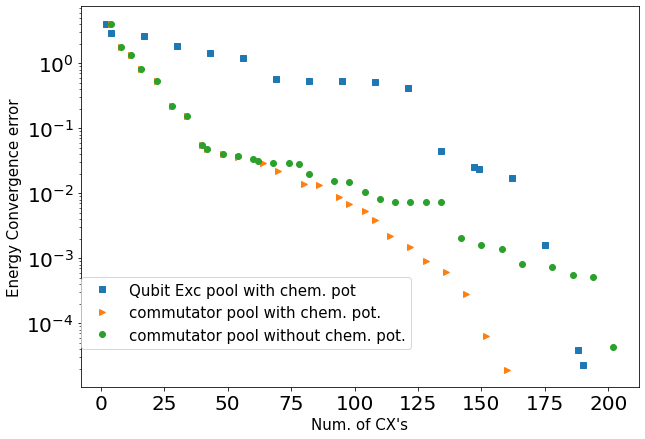

In [40]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,1,figsize = (10,7))
ax.set_yscale('log')
ax.set_xlabel("Num. of CX's",fontsize=15)
ax.set_ylabel('Energy Convergence error',fontsize=15)
#ax.set_yticks((10**1,1,10**(-1),10**(-2)))
ax.plot(CXs2,numpy.array(EnergyArr2)-Eg,marker='s',linestyle='',label='Qubit Exc pool with chem. pot')
ax.plot(CXs1,numpy.array(EnergyArr1)-Eg,marker='>',linestyle='',label='commutator pool with chem. pot.')
ax.plot(CXs3,numpy.array(EnergyArr3)-Eg0,marker='o',linestyle='',label="commutator pool without chem. pot.")
ax.tick_params(labelsize=20)
plt.legend(fontsize=15,loc=(0.0,0.1))
plt.savefig("ErrorConvergence_eg.png")

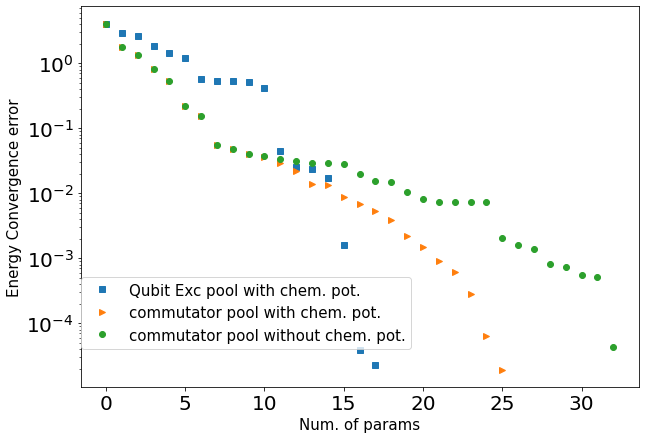

In [42]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,1,figsize = (10,7))
ax.set_yscale('log')
ax.set_xlabel("Num. of params",fontsize=15)
ax.set_ylabel('Energy Convergence error',fontsize=15)
#ax.set_yticks((10**1,1,10**(-1),10**(-2)))
ax.plot(numpy.array(EnergyArr2)-Eg,marker='s',linestyle='',label='Qubit Exc pool with chem. pot.')
ax.plot(numpy.array(EnergyArr1)-Eg,marker='>',linestyle='',label='commutator pool with chem. pot.')
ax.plot(numpy.array(EnergyArr3)-Eg0,marker='o',linestyle='',label="commutator pool without chem. pot.")
ax.tick_params(labelsize=20)
plt.legend(fontsize=15,loc=(0.0,0.1))
plt.savefig("ErrorConvergence_eg_with_params.png")